### Nous allons ici faire du Fine-tuning de quelques modèles avec les données du fichier data_classification_2.csv 

SBERT, RoBERTa

In [1]:
import pandas as pd 

data = pd.read_csv("data/data_classification_2.csv", keep_default_na=False)

data.head()

,text,tokens_clean,text_clean,type_article,thematique
0,Microbial Community Composition Associated wit...,"['microbial', 'community', 'composition', 'ass...",microbial community composition associated pot...,VS,SV
1,Plant Pathogenic and Endophytic Colletotrichum...,"['plant', 'pathogenic', 'endophytic', 'colleto...",plant pathogenic endophytic colletotrichum fru...,VS,SV
2,Lethal Bronzing: What you should know about th...,"['lethal', 'bronzing', 'know', 'disease', 'tur...",lethal bronzing know disease turn palm tree br...,VS,SV
3,Leaffooted Bug Damage in Almond Orchards Leaff...,"['leaffooted', 'bug', 'damage', 'almond', 'orc...",leaffooted bug damage almond orchard leaffoote...,VS,SV
4,Kebbi govt battles mysterious disease affectin...,"['kebbi', 'govt', 'battle', 'mysterious', 'dis...",kebbi govt battle mysterious disease affecting...,VS,SV


#### Fine-tuning de RoBERTa avec la classe Trainer de Hugging Face

In [ ]:
# =========================
# 0) Imports
# =========================
import os, json, joblib, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# =========================
# 1) Données + indices figés
# =========================
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# <<< IMPORTANT : données brutes >>>
X_all = data["text"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# =========================
# 2) Encodage des labels
# =========================
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
num_classes = len(label_encoder.classes_)
print("Classes:", list(label_encoder.classes_))

# =========================
# 3) Split par indices
# =========================
X_train, X_val, X_test = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# =========================
# 4) Tokenizer & modèle (RoBERTa-base)
# =========================
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# =========================
# 5) Dataset PyTorch (robuste aux NaN)
# =========================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = ["" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t) for t in texts]
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist() if isinstance(labels, np.ndarray) else list(labels)
        assert len(self.texts) == len(self.labels), "Taille textes/labels incohérente."

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer, max_length=256)
val_ds   = TextDataset(X_val,   y_val,   tokenizer, max_length=256)
test_ds  = TextDataset(X_test,  y_test,  tokenizer, max_length=256)

# =========================
# 6) Metrics
# =========================
def compute_metrics(eval_pred):
    # Compat EvalPrediction / (logits, labels)
    if hasattr(eval_pred, "predictions"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

# =========================
# 7) Callbacks (VAL + early stop custom) & (TRAIN logging)
# =========================
class ValEvalAndEarlyStopCallback(TrainerCallback):
    """
    - Évalue sur VAL à la fin de chaque epoch
    - Loggue 'eval_*' dans log_history
    - Early stopping custom basé sur metric_for_best_model / greater_is_better
    - Sauvegarde le meilleur modèle dans output_dir/best_checkpoint
    """
    def __init__(self, trainer, patience=3):
        self.trainer = trainer
        self.patience = patience
        self.best_metric = None
        self.best_epoch = None
        self.bad_epochs = 0
        self.best_dir = os.path.join(str(trainer.args.output_dir), "best_checkpoint")
        os.makedirs(self.best_dir, exist_ok=True)
        self.metric_name = trainer.args.metric_for_best_model or "eval_loss"
        self.greater_is_better = bool(trainer.args.greater_is_better)

    def _is_better(self, current, best):
        if best is None:
            return True
        return (current > best) if self.greater_is_better else (current < best)

    def on_epoch_end(self, args, state, control, **kwargs):
        # 1) Eval VAL
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.trainer.eval_dataset,
                metric_key_prefix="eval"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        # 2) Logger avec epoch
        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})

        # 3) Early stopping
        current = metrics.get(self.metric_name, None)
        if current is None or (isinstance(current, float) and math.isnan(current)):
            return control

        if self._is_better(current, self.best_metric):
            self.best_metric = current
            self.best_epoch = int(round(state.epoch)) if state.epoch is not None else None
            self.bad_epochs = 0
            # Save best
            self.trainer.save_model(self.best_dir)
            if getattr(self.trainer, "tokenizer", None) is not None:
                self.trainer.tokenizer.save_pretrained(self.best_dir)
            control.should_save = True
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                control.should_training_stop = True

        return control

class TrainEvalCallback(TrainerCallback):
    """Évalue sur TRAIN à la fin de chaque epoch et loggue train_*."""
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.train_dataset,
                metric_key_prefix="train"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.train_dataset)
            metrics = {f"train_{k}": v for k, v in metrics.items()}

        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})
        return control

# =========================
# 8) TrainingArguments + Trainer
# =========================
training_args = TrainingArguments(
    output_dir="./results_RoBERTa",
    num_train_epochs=50,                 # large, l'early stop coupera
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",         # si non supporté, nos callbacks couvrent le besoin
    save_strategy="epoch",
    load_best_model_at_end=False,        # on gère le "best" nous-mêmes (best_checkpoint)
    metric_for_best_model="eval_loss",   # ou "eval_f1_macro"
    greater_is_better=False,             # True si "eval_f1_macro"
    logging_dir="./logs_RoBERTa",
    logging_strategy="epoch",
    report_to="none",
    save_total_limit=3,
    seed=SEED,
    dataloader_pin_memory=False,         # évite le warning CPU
    # fp16=True,                         # à activer si GPU FP16 dispo
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,                 # pour sauvegarder aussi le tokenizer du best
    callbacks=[]                         # pas d'EarlyStopping natif HF
)

# Brancher les callbacks
trainer.add_callback(ValEvalAndEarlyStopCallback(trainer, patience=3))
trainer.add_callback(TrainEvalCallback(trainer, train_ds))

# =========================
# 9) Entraînement
# =========================
trainer.train()

# =========================
# 10) Historique -> courbes (robuste)
# =========================
log_hist = trainer.state.log_history
hist_df = pd.DataFrame(log_hist).copy()

needed = [
    "epoch","eval_loss","eval_accuracy","eval_f1_macro",
    "train_loss","train_accuracy","train_f1_macro",
    "train_precision_macro","train_recall_macro"
]
for c in needed:
    if c not in hist_df.columns: hist_df[c] = np.nan

hist_df = hist_df[pd.to_numeric(hist_df["epoch"], errors="coerce").notna()].copy()
hist_df["epoch"] = hist_df["epoch"].astype(float).round().astype(int)

for c in [x for x in needed if x != "epoch"]:
    hist_df[c] = pd.to_numeric(hist_df[c], errors="coerce")

def last_not_nan(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

curves = (
    hist_df
    .sort_values(["epoch"])
    .groupby("epoch", as_index=False)
    .agg({col: last_not_nan for col in needed if col != "epoch"})
    .sort_values("epoch")
    .reset_index(drop=True)
)

print("\nAperçu des courbes (par epoch):\n", curves.head(10))

def _safe_plot(x, y, label):
    s = pd.Series(y)
    if s.notna().any():
        plt.plot(x, y, marker="o", label=label)

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_loss"], "Train Loss")
_safe_plot(curves["epoch"], curves["eval_loss"],  "Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("RoBERTa — Loss (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_accuracy"], "Train Acc")
_safe_plot(curves["epoch"], curves["eval_accuracy"],  "Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("RoBERTa — Accuracy (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_f1_macro"], "Train F1 (macro)")
_safe_plot(curves["epoch"], curves["eval_f1_macro"],  "Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.title("RoBERTa — F1 macro (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# =========================
# 11) Évaluation finale sur TEST (avec le meilleur modèle)
# =========================
best_dir = os.path.join(training_args.output_dir, "best_checkpoint")
if os.path.isdir(best_dir):
    model = AutoModelForSequenceClassification.from_pretrained(best_dir).to(model.device)
    trainer.model = model
    print(f"\nBest checkpoint utilisé pour TEST: {best_dir}")

preds_test = trainer.predict(test_ds)
y_pred = np.argmax(preds_test.predictions, axis=1)
y_scores = torch.softmax(torch.tensor(preds_test.predictions), dim=1).numpy()

print("\n=== Rapport de classification (TEST) — RoBERTa fine-tuné ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.title("Matrice de confusion — TEST (RoBERTa)")
plt.tight_layout()
plt.show()

# Courbe PR pour "VS" si présent
classes = list(label_encoder.classes_)
if "VS" in classes:
    vs_idx = classes.index("VS")
    y_true_bin = (y_test == vs_idx).astype(int)
    y_prob_vs = y_scores[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (classe VS) — TEST (RoBERTa)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Classe 'VS' absente — PR-curve sautée.")

# =========================
# 12) Sauvegardes
# =========================
save_dir = "results_RoBERTa_final"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.joblib"))

curves.to_csv(os.path.join(save_dir, "learning_curves.csv"), index=False)
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(log_hist, f, ensure_ascii=False, indent=2)

print("\nTerminé. Courbes + meilleur modèle sauvegardés.")


Classes: ['NVS', 'VS']


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Rosalie\Classification_2\.venv\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/5450 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.10593686252832413, 'eval_accuracy': 0.9731800766283525, 'eval_f1_macro': 0.9252454991816694, 'eval_precision_macro': 0.9252454991816694, 'eval_recall_macro': 0.9252454991816694, 'eval_runtime': 88.2938, 'eval_samples_per_second': 5.912, 'eval_steps_per_second': 0.102, 'epoch': 1.0}
{'eval_loss': 0.10593686252832413, 'eval_accuracy': 0.9731800766283525, 'eval_f1_macro': 0.9252454991816694, 'eval_precision_macro': 0.9252454991816694, 'eval_recall_macro': 0.9252454991816694, 'eval_runtime': 88.2938, 'eval_samples_per_second': 5.912, 'eval_steps_per_second': 0.102, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.1036166250705719, 'train_accuracy': 0.9747561675272519, 'train_f1_macro': 0.927152041095474, 'train_precision_macro': 0.943965176879343, 'train_recall_macro': 0.9118865519439133, 'train_runtime': 316.4333, 'train_samples_per_second': 5.508, 'train_steps_per_second': 0.088, 'epoch': 1.0}
{'train_loss': 0.1036166250705719, 'train_accuracy': 0.9747561675272519, 'train_f1_macro': 0.927152041095474, 'train_precision_macro': 0.943965176879343, 'train_recall_macro': 0.9118865519439133, 'train_runtime': 316.4333, 'train_samples_per_second': 5.508, 'train_steps_per_second': 0.088, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.11257471889257431, 'eval_accuracy': 0.9731800766283525, 'eval_f1_macro': 0.9321120689655172, 'eval_precision_macro': 0.8973457969432315, 'eval_recall_macro': 0.9765548281505728, 'eval_runtime': 99.525, 'eval_samples_per_second': 5.245, 'eval_steps_per_second': 0.09, 'epoch': 2.0}
{'eval_loss': 0.11257471889257431, 'eval_accuracy': 0.9731800766283525, 'eval_f1_macro': 0.9321120689655172, 'eval_precision_macro': 0.8973457969432315, 'eval_recall_macro': 0.9765548281505728, 'eval_runtime': 99.525, 'eval_samples_per_second': 5.245, 'eval_steps_per_second': 0.09, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.03576334938406944, 'train_accuracy': 0.9913941480206541, 'train_f1_macro': 0.9764778386062141, 'train_precision_macro': 0.9683328499373944, 'train_recall_macro': 0.9850003296630843, 'train_runtime': 344.8618, 'train_samples_per_second': 5.054, 'train_steps_per_second': 0.081, 'epoch': 2.0}
{'train_loss': 0.03576334938406944, 'train_accuracy': 0.9913941480206541, 'train_f1_macro': 0.9764778386062141, 'train_precision_macro': 0.9683328499373944, 'train_recall_macro': 0.9850003296630843, 'train_runtime': 344.8618, 'train_samples_per_second': 5.054, 'train_steps_per_second': 0.081, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.17758701741695404, 'eval_accuracy': 0.9597701149425287, 'eval_f1_macro': 0.9032334948756653, 'eval_precision_macro': 0.858046282127354, 'eval_recall_macro': 0.9691080196399345, 'eval_runtime': 87.7016, 'eval_samples_per_second': 5.952, 'eval_steps_per_second': 0.103, 'epoch': 3.0}
{'eval_loss': 0.17758701741695404, 'eval_accuracy': 0.9597701149425287, 'eval_f1_macro': 0.9032334948756653, 'eval_precision_macro': 0.858046282127354, 'eval_recall_macro': 0.9691080196399345, 'eval_runtime': 87.7016, 'eval_samples_per_second': 5.952, 'eval_steps_per_second': 0.103, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.06933454424142838, 'train_accuracy': 0.9804934021801491, 'train_f1_macro': 0.949320996100431, 'train_precision_macro': 0.9222939328326083, 'train_recall_macro': 0.9815004065844706, 'train_runtime': 301.8971, 'train_samples_per_second': 5.773, 'train_steps_per_second': 0.093, 'epoch': 3.0}
{'train_loss': 0.06933454424142838, 'train_accuracy': 0.9804934021801491, 'train_f1_macro': 0.949320996100431, 'train_precision_macro': 0.9222939328326083, 'train_recall_macro': 0.9815004065844706, 'train_runtime': 301.8971, 'train_samples_per_second': 5.773, 'train_steps_per_second': 0.093, 'epoch': 3.0}


Ce fine-tuning RoBERTa prend trop de temps, nous allons essayer de lancer le fine-tuning de SBERT 

### Fine-tuning de SBERT avec Trainer 

### Créeons des indices des splits qu'on pourra utiliser pour comparer ce fine-tuning avec TF-IDF + XG-BOOST qui fonctionne mieux jusqu'à présent avec peu de ressources 

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split

SEED = 42
N = len(data)

idx_all = np.arange(N)
y = data["type_article"].to_numpy()


idx_train, idx_temp, y_train_tmp, y_temp_tmp = train_test_split(
    idx_all, y, test_size=0.3, stratify=y, random_state=SEED
)
idx_val, idx_test, _, _ = train_test_split(
    idx_temp, y_temp_tmp, test_size=0.3, stratify=y_temp_tmp, random_state=SEED
)

np.save("splits_idx_train.npy", idx_train)
np.save("splits_idx_val.npy",   idx_val)
np.save("splits_idx_test.npy",  idx_test)
print(len(idx_train), len(idx_val), len(idx_test))


1743 522 225


### Fine-tuning de SBERT 

Nous le faisons sur les données brutes (pas de tokenisation, lemmatisation...)

Classes: ['NVS', 'VS']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/all-MiniLM-L6-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Rosalie\Classification_2\.venv\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2180 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.10928507894277573, 'eval_accuracy': 0.9693486590038314, 'eval_f1_macro': 0.9115254237288135, 'eval_precision_macro': 0.926951476793249, 'eval_recall_macro': 0.8974631751227495, 'eval_runtime': 22.3724, 'eval_samples_per_second': 23.332, 'eval_steps_per_second': 0.402, 'epoch': 1.0}
{'eval_loss': 0.10928507894277573, 'eval_accuracy': 0.9693486590038314, 'eval_f1_macro': 0.9115254237288135, 'eval_precision_macro': 0.926951476793249, 'eval_recall_macro': 0.8974631751227495, 'eval_runtime': 22.3724, 'eval_samples_per_second': 23.332, 'eval_steps_per_second': 0.402, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.11378870159387589, 'train_accuracy': 0.9672977624784854, 'train_f1_macro': 0.8993837506646074, 'train_precision_macro': 0.9488710219887102, 'train_recall_macro': 0.86175578558713, 'train_runtime': 75.0161, 'train_samples_per_second': 23.235, 'train_steps_per_second': 0.373, 'epoch': 1.0}
{'train_loss': 0.11378870159387589, 'train_accuracy': 0.9672977624784854, 'train_f1_macro': 0.8993837506646074, 'train_precision_macro': 0.9488710219887102, 'train_recall_macro': 0.86175578558713, 'train_runtime': 75.0161, 'train_samples_per_second': 23.235, 'train_steps_per_second': 0.373, 'epoch': 1.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.10148672759532928, 'eval_accuracy': 0.9674329501915708, 'eval_f1_macro': 0.9193822393822393, 'eval_precision_macro': 0.879498113826472, 'eval_recall_macro': 0.9733633387888707, 'eval_runtime': 28.5696, 'eval_samples_per_second': 18.271, 'eval_steps_per_second': 0.315, 'epoch': 2.0}
{'eval_loss': 0.10148672759532928, 'eval_accuracy': 0.9674329501915708, 'eval_f1_macro': 0.9193822393822393, 'eval_precision_macro': 0.879498113826472, 'eval_recall_macro': 0.9733633387888707, 'eval_runtime': 28.5696, 'eval_samples_per_second': 18.271, 'eval_steps_per_second': 0.315, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.1004517674446106, 'train_accuracy': 0.9661503155479059, 'train_f1_macro': 0.9130713733247112, 'train_precision_macro': 0.8846571180555556, 'train_recall_macro': 0.9479846596778093, 'train_runtime': 94.5528, 'train_samples_per_second': 18.434, 'train_steps_per_second': 0.296, 'epoch': 2.0}
{'train_loss': 0.1004517674446106, 'train_accuracy': 0.9661503155479059, 'train_f1_macro': 0.9130713733247112, 'train_precision_macro': 0.8846571180555556, 'train_recall_macro': 0.9479846596778093, 'train_runtime': 94.5528, 'train_samples_per_second': 18.434, 'train_steps_per_second': 0.296, 'epoch': 2.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.09746074676513672, 'eval_accuracy': 0.9597701149425287, 'eval_f1_macro': 0.9018471925002014, 'eval_precision_macro': 0.8601113350609464, 'eval_recall_macro': 0.9605564648117839, 'eval_runtime': 22.4746, 'eval_samples_per_second': 23.226, 'eval_steps_per_second': 0.4, 'epoch': 3.0}
{'eval_loss': 0.09746074676513672, 'eval_accuracy': 0.9597701149425287, 'eval_f1_macro': 0.9018471925002014, 'eval_precision_macro': 0.8601113350609464, 'eval_recall_macro': 0.9605564648117839, 'eval_runtime': 22.4746, 'eval_samples_per_second': 23.226, 'eval_steps_per_second': 0.4, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.06112932041287422, 'train_accuracy': 0.9764773379231211, 'train_f1_macro': 0.9381628759199249, 'train_precision_macro': 0.9158709885015202, 'train_recall_macro': 0.9639403529592756, 'train_runtime': 73.3092, 'train_samples_per_second': 23.776, 'train_steps_per_second': 0.382, 'epoch': 3.0}
{'train_loss': 0.06112932041287422, 'train_accuracy': 0.9764773379231211, 'train_f1_macro': 0.9381628759199249, 'train_precision_macro': 0.9158709885015202, 'train_recall_macro': 0.9639403529592756, 'train_runtime': 73.3092, 'train_samples_per_second': 23.776, 'train_steps_per_second': 0.382, 'epoch': 3.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.09452853351831436, 'eval_accuracy': 0.9770114942528736, 'eval_f1_macro': 0.9390305625851665, 'eval_precision_macro': 0.9191810344827587, 'eval_recall_macro': 0.9615793780687398, 'eval_runtime': 22.4906, 'eval_samples_per_second': 23.21, 'eval_steps_per_second': 0.4, 'epoch': 4.0}
{'eval_loss': 0.09452853351831436, 'eval_accuracy': 0.9770114942528736, 'eval_f1_macro': 0.9390305625851665, 'eval_precision_macro': 0.9191810344827587, 'eval_recall_macro': 0.9615793780687398, 'eval_runtime': 22.4906, 'eval_samples_per_second': 23.21, 'eval_steps_per_second': 0.4, 'epoch': 4.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.033873267471790314, 'train_accuracy': 0.9931153184165232, 'train_f1_macro': 0.9807481315120945, 'train_precision_macro': 0.9832372359480703, 'train_recall_macro': 0.9782916858970132, 'train_runtime': 76.6658, 'train_samples_per_second': 22.735, 'train_steps_per_second': 0.365, 'epoch': 4.0}
{'train_loss': 0.033873267471790314, 'train_accuracy': 0.9931153184165232, 'train_f1_macro': 0.9807481315120945, 'train_precision_macro': 0.9832372359480703, 'train_recall_macro': 0.9782916858970132, 'train_runtime': 76.6658, 'train_samples_per_second': 22.735, 'train_steps_per_second': 0.365, 'epoch': 4.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.1371663212776184, 'eval_accuracy': 0.9655172413793104, 'eval_f1_macro': 0.9152597402597402, 'eval_precision_macro': 0.873898678414097, 'eval_recall_macro': 0.9722995090016366, 'eval_runtime': 21.9996, 'eval_samples_per_second': 23.728, 'eval_steps_per_second': 0.409, 'epoch': 5.0}
{'eval_loss': 0.1371663212776184, 'eval_accuracy': 0.9655172413793104, 'eval_f1_macro': 0.9152597402597402, 'eval_precision_macro': 0.873898678414097, 'eval_recall_macro': 0.9722995090016366, 'eval_runtime': 21.9996, 'eval_samples_per_second': 23.728, 'eval_steps_per_second': 0.409, 'epoch': 5.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.020875515416264534, 'train_accuracy': 0.9954102122776821, 'train_f1_macro': 0.9873600394500204, 'train_precision_macro': 0.9825070897799476, 'train_recall_macro': 0.992340827674117, 'train_runtime': 74.3223, 'train_samples_per_second': 23.452, 'train_steps_per_second': 0.377, 'epoch': 5.0}
{'train_loss': 0.020875515416264534, 'train_accuracy': 0.9954102122776821, 'train_f1_macro': 0.9873600394500204, 'train_precision_macro': 0.9825070897799476, 'train_recall_macro': 0.992340827674117, 'train_runtime': 74.3223, 'train_samples_per_second': 23.452, 'train_steps_per_second': 0.377, 'epoch': 5.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.2144753336906433, 'eval_accuracy': 0.9578544061302682, 'eval_f1_macro': 0.8993338008415148, 'eval_precision_macro': 0.8530555555555556, 'eval_recall_macro': 0.9680441898527005, 'eval_runtime': 29.0046, 'eval_samples_per_second': 17.997, 'eval_steps_per_second': 0.31, 'epoch': 6.0}
{'eval_loss': 0.2144753336906433, 'eval_accuracy': 0.9578544061302682, 'eval_f1_macro': 0.8993338008415148, 'eval_precision_macro': 0.8530555555555556, 'eval_recall_macro': 0.9680441898527005, 'eval_runtime': 29.0046, 'eval_samples_per_second': 17.997, 'eval_steps_per_second': 0.31, 'epoch': 6.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.017723657190799713, 'train_accuracy': 0.9959839357429718, 'train_f1_macro': 0.9889678457144045, 'train_precision_macro': 0.982920530369058, 'train_recall_macro': 0.9952143908925078, 'train_runtime': 98.1343, 'train_samples_per_second': 17.761, 'train_steps_per_second': 0.285, 'epoch': 6.0}
{'train_loss': 0.017723657190799713, 'train_accuracy': 0.9959839357429718, 'train_f1_macro': 0.9889678457144045, 'train_precision_macro': 0.982920530369058, 'train_recall_macro': 0.9952143908925078, 'train_runtime': 98.1343, 'train_samples_per_second': 17.761, 'train_steps_per_second': 0.285, 'epoch': 6.0}


  0%|          | 0/9 [00:00<?, ?it/s]

{'eval_loss': 0.11548793315887451, 'eval_accuracy': 0.9712643678160919, 'eval_f1_macro': 0.9255724646635552, 'eval_precision_macro': 0.8983855481668503, 'eval_recall_macro': 0.9583878887070376, 'eval_runtime': 22.2103, 'eval_samples_per_second': 23.503, 'eval_steps_per_second': 0.405, 'epoch': 7.0}
{'eval_loss': 0.11548793315887451, 'eval_accuracy': 0.9712643678160919, 'eval_f1_macro': 0.9255724646635552, 'eval_precision_macro': 0.8983855481668503, 'eval_recall_macro': 0.9583878887070376, 'eval_runtime': 22.2103, 'eval_samples_per_second': 23.503, 'eval_steps_per_second': 0.405, 'epoch': 7.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'train_loss': 0.006610301788896322, 'train_accuracy': 0.9982788296041308, 'train_f1_macro': 0.9952238418798461, 'train_precision_macro': 0.9939668367346939, 'train_recall_macro': 0.9964890881519087, 'train_runtime': 75.6515, 'train_samples_per_second': 23.04, 'train_steps_per_second': 0.37, 'epoch': 7.0}
{'train_loss': 0.006610301788896322, 'train_accuracy': 0.9982788296041308, 'train_f1_macro': 0.9952238418798461, 'train_precision_macro': 0.9939668367346939, 'train_recall_macro': 0.9964890881519087, 'train_runtime': 75.6515, 'train_samples_per_second': 23.04, 'train_steps_per_second': 0.37, 'epoch': 7.0}
{'train_runtime': 5097.744, 'train_samples_per_second': 6.838, 'train_steps_per_second': 0.428, 'train_loss': 0.09312535957146441, 'epoch': 7.0}

Aperçu des courbes (par epoch):
    epoch  eval_loss  eval_accuracy  eval_f1_macro  train_loss  train_accuracy  \
0      1   0.109285       0.969349       0.911525    0.113789        0.967298   
1      2   0.101487       0.967433       0.91

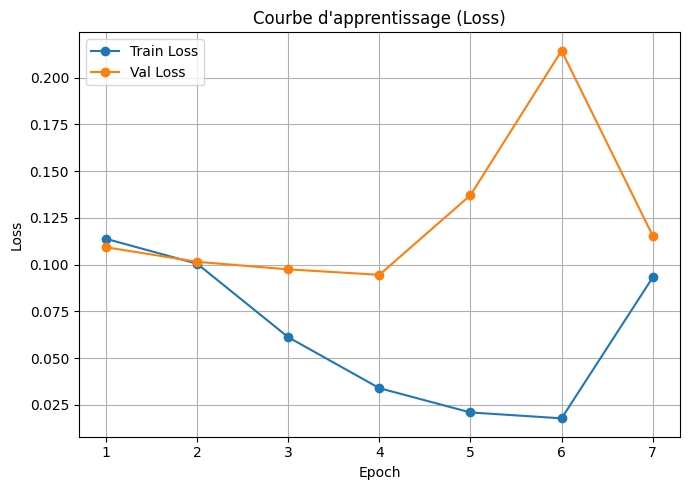

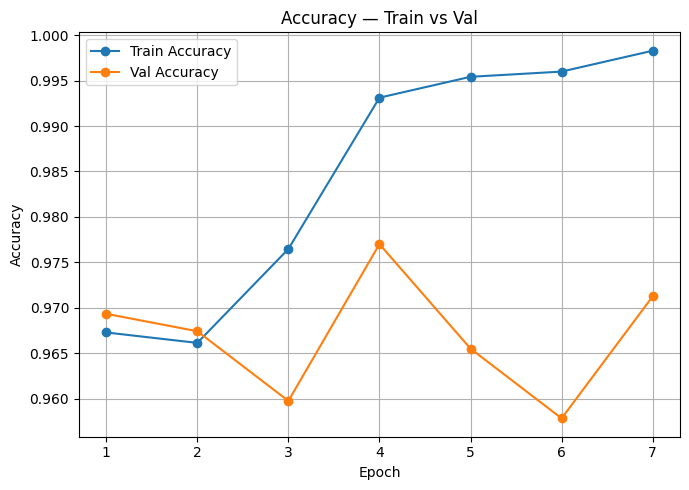

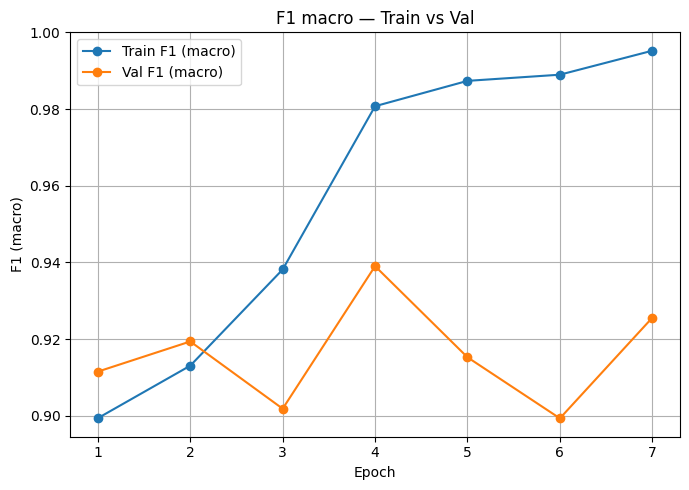

  0%|          | 0/4 [00:00<?, ?it/s]


=== Rapport de classification (TEST) ===
              precision    recall  f1-score   support

         NVS       1.00      1.00      1.00       202
          VS       0.96      0.96      0.96        23

    accuracy                           0.99       225
   macro avg       0.98      0.98      0.98       225
weighted avg       0.99      0.99      0.99       225



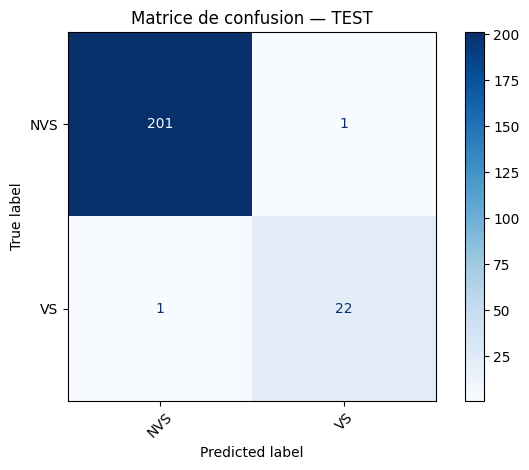

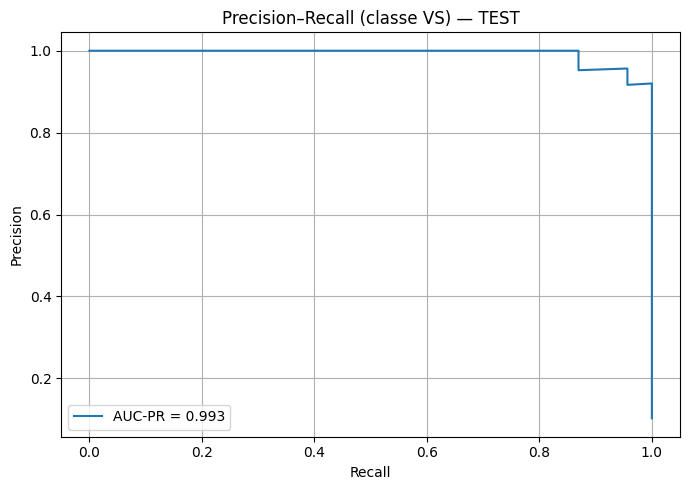


Best model saved to: ./results_SBERT\best_checkpoint (metric eval_f1_macro with greater_is_better=True)


In [16]:
# =========================
# 0) Imports
# =========================
import os, json, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# =========================
# 1) Données + indices sauvegardés
# =========================
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

X_all = data["text"].astype(str).to_numpy() # Nous lançons l'entrainnement sur les données brutes 
y_all = data["type_article"].to_numpy()

# Encodage labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
num_classes = len(label_encoder.classes_)
print("Classes:", list(label_encoder.classes_))

# Splits
X_train, X_val, X_test = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# =========================
# 2) Tokenizer & modèle
# =========================
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# =========================
# 3) Dataset PyTorch (robuste)
# =========================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        self.texts = [
            "" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t)
            for t in texts
        ]
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist() if isinstance(labels, np.ndarray) else list(labels)
        assert len(self.texts) == len(self.labels)

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer)
val_ds   = TextDataset(X_val,   y_val,   tokenizer)
test_ds  = TextDataset(X_test,  y_test,  tokenizer)

# =========================
# 4) Metrics + Callback TrainEval
# =========================
def compute_metrics(eval_pred):
    # Compat: EvalPrediction (HF récent) ou tuple (anciens)
    if hasattr(eval_pred, "predictions"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

from transformers import TrainerCallback
import math, os

class ValEvalAndEarlyStopCallback(TrainerCallback):
    """
    - Évalue sur le set de validation à la fin de chaque epoch
    - Loggue les métriques 'eval_*' dans log_history
    - Early stopping custom basé sur training_args.metric_for_best_model et greater_is_better
    - Sauvegarde le meilleur modèle dans output_dir/best_checkpoint
    """
    def __init__(self, trainer, patience=3):
        self.trainer = trainer
        self.patience = patience
        self.best_metric = None
        self.best_epoch = None
        self.bad_epochs = 0
        self.best_dir = os.path.join(str(trainer.args.output_dir), "best_checkpoint")
        os.makedirs(self.best_dir, exist_ok=True)

        # lit la config d'arrêt
        self.metric_name = trainer.args.metric_for_best_model or "eval_loss"
        self.greater_is_better = bool(trainer.args.greater_is_better)

    def _is_better(self, current, best):
        if best is None:
            return True
        return (current > best) if self.greater_is_better else (current < best)

    def on_epoch_end(self, args, state, control, **kwargs):
        # 1) Évaluer VAL
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.trainer.eval_dataset,
                metric_key_prefix="eval"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        # 2) Ajouter l'epoch et logger explicitement
        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})

        # 3) Early stopping custom
        current = metrics.get(self.metric_name, None)
        if current is None or (isinstance(current, float) and math.isnan(current)):
            # rien à faire si la métrique n'est pas là
            return control

        if self._is_better(current, self.best_metric):
            # Amélioration -> reset patience + save best
            self.best_metric = current
            self.best_epoch = int(round(state.epoch)) if state.epoch is not None else None
            self.bad_epochs = 0
            # Sauvegarder le meilleur modèle
            self.trainer.save_model(self.best_dir)
            if hasattr(self.trainer, "tokenizer") and self.trainer.tokenizer is not None:
                self.trainer.tokenizer.save_pretrained(self.best_dir)
            control.should_save = True
        else:
            # Pas d'amélioration
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                # Stopper l'entraînement
                control.should_training_stop = True

        return control
    

# Pour avoir aussi les retours sur le jeux d'entrainement
class TrainEvalCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        # Évalue sur TRAIN et logue train_*
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.train_dataset,
                metric_key_prefix="train"  # => train_loss, train_accuracy, ...
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.train_dataset)
            # Rétro-compat: préfixer manuellement si besoin
            metrics = {f"train_{k}": v for k, v in metrics.items()}

        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)

        # pousse dans log_history (même avec report_to='none')
        self.trainer.log({k: float(v) for k, v in metrics.items() if isinstance(v, (int, float, np.floating))})
        return control


# =========================
# 5) TrainingArguments + Trainer + EarlyStopping
# =========================
training_args = TrainingArguments(
    output_dir="./results_SBERT",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./logs_SBERT",
    logging_strategy="epoch",
    report_to="none",
    save_total_limit=3,
    seed=SEED,
    dataloader_pin_memory=False,
    # fp16=True,  # à activer si GPU FP16 dispo
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks=[]  # <= pas de EarlyStoppingCallback natif
)

# Callback VAL + early stop custom
val_es_cb = ValEvalAndEarlyStopCallback(trainer, patience=3)
trainer.add_callback(val_es_cb)

# Callback TRAIN pour avoir train_* dans les courbes
train_cb = TrainEvalCallback(trainer, train_ds)
trainer.add_callback(train_cb)



# =========================
# 6) Entraînement
# =========================
trainer.train()

# =========================
# 7) Historique pour tracés (robuste aux clés manquantes)
# =========================
log_hist = trainer.state.log_history
hist_df = pd.DataFrame(log_hist)

# Crée toutes les colonnes attendues si absentes pour éviter KeyError
needed_cols = ["epoch","eval_loss","eval_accuracy","eval_f1_macro",
          "train_loss","train_accuracy","train_f1_macro",
          "train_precision_macro","train_recall_macro"]
for c in needed_cols:
    if c not in hist_df.columns:
        hist_df[c] = np.nan

# Ne garder que les lignes avec epoch défini et forcer epoch en int
hist_df = hist_df[pd.to_numeric(hist_df["epoch"], errors="coerce").notna()].copy()
hist_df["epoch"] = hist_df["epoch"].astype(float).round().astype(int)

# Convertir toutes les métriques numériques en float (coerce -> NaN si non num)
metric_cols = [c for c in needed_cols if c != "epoch"]
for c in metric_cols:
    hist_df[c] = pd.to_numeric(hist_df[c], errors="coerce")

# Fonction utilitaire: dernière valeur non-NaN dans un groupe
def last_not_nan(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

# Agrégation par epoch: on prend la DERNIÈRE valeur non-NaN de chaque métrique
curves = (
    hist_df
    .sort_values(["epoch"])  # important: on veut la "dernière" dans l'ordre
    .groupby("epoch", as_index=False)
    .agg({col: last_not_nan for col in metric_cols})
    .sort_values("epoch")
    .reset_index(drop=True)
)

print("\nAperçu des courbes (par epoch):\n", curves.head(10))
# ============================================================================

# Exemple de tracés "safe"
def _safe_plot(x, y, label):
    s = pd.Series(y)
    if s.notna().any():
        plt.plot(x, y, marker="o", label=label)

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_loss"], "Train Loss")
_safe_plot(curves["epoch"], curves["eval_loss"],  "Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Courbe d'apprentissage (Loss)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_accuracy"], "Train Accuracy")
_safe_plot(curves["epoch"], curves["eval_accuracy"],  "Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_f1_macro"], "Train F1 (macro)")
_safe_plot(curves["epoch"], curves["eval_f1_macro"],  "Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.title("F1 macro — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# =========================
# 9) Évaluation finale sur TEST
# =========================
# Recharger le meilleur modèle pour la phase TEST
best_dir = os.path.join(training_args.output_dir, "best_checkpoint")
if os.path.isdir(best_dir):
    model = AutoModelForSequenceClassification.from_pretrained(best_dir).to(model.device)
    trainer.model = model

preds_test = trainer.predict(test_ds)
y_pred = np.argmax(preds_test.predictions, axis=1)
y_scores = torch.softmax(torch.tensor(preds_test.predictions), dim=1).numpy()

print("\n=== Rapport de classification (TEST) ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.title("Matrice de confusion — TEST")
plt.tight_layout()
plt.show()

# Courbe PR pour "VS" si présent
classes = list(label_encoder.classes_)
if "VS" in classes:
    vs_idx = classes.index("VS")
    y_true_bin = (y_test == vs_idx).astype(int)
    y_prob_vs = y_scores[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (classe VS) — TEST")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("La classe 'VS' n'est pas présente dans les labels. PR-curve sautée.")

# =========================
# 10) Sauvegardes
# =========================
save_dir = "results_SBERT"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.joblib"))

curves.to_csv(os.path.join(save_dir, "learning_curves.csv"), index=False)
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(log_hist, f, ensure_ascii=False, indent=2)

print(f"\nBest model saved to: {best_dir} (metric {training_args.metric_for_best_model} "
      f"with greater_is_better={training_args.greater_is_better})")


### Nous allons essayer d'obtenir des explications par tokens (mot/sous-mots) de notre modèle fine-tuné avec l'option *Integrated Gradients (Captum)* sur la couche d'embedding du modèle. 

L'avantage de cette option est qu'elle est assez fidèle et on n'a pas besoin de pertuber le texte comme LIME/SHAP

In [19]:
import os, json, joblib, re, numpy as np, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import nltk

# ========= 0) Réglages =========
SAVE_DIR = "results_SBERT"
APPLY_CLEANING = True           # Mettons False si nous fine-tunons sur texte brut
TOPK = 15                       # nb de tokens à garder par sample
N_STEPS = 32                    # IG steps (32-64 raisonnable)
MAX_LEN = 256
ONLY_FOR_VS = False             # True -> ne calcule IG que pour les prédictions VS (plus rapide)
AGGREGATE_SUBWORDS = True       # aggréger "##" pour lire des mots entiers
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 1) NLTK =========
if APPLY_CLEANING:
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    custom_stopwords = {"et", "al"}

    def nettoyer_texte(texte: str) -> str:
        tokens = word_tokenize(texte)
        out = []
        for tok in tokens:
            tok = tok.lower()
            tok = re.sub(r"\s+", "", tok)
            tok = re.sub(r"[^a-zàâçéèêëîïôûùüÿñæœ]", "", tok)
            if tok and tok not in stop_words and tok not in punctuation and tok not in custom_stopwords:
                tok = lemmatizer.lemmatize(tok)
                out.append(tok)
        return " ".join(out)

def maybe_clean(text):
    return nettoyer_texte(text) if APPLY_CLEANING else text

# ========= 2) Charger modèle + tokenizer + labels =========
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR).to(DEVICE)
model.eval()
le = joblib.load(os.path.join(SAVE_DIR, "label_encoder.joblib"))
classes = list(le.classes_)
target_label = "VS" if "VS" in classes else classes[1]
target_idx = classes.index(target_label)

def forward_embeds(inputs_embeds, attention_mask):
    out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    return torch.softmax(out.logits, dim=1)

# ========= 3) Données de test via indices figés =========
idx_test = np.load("splits_idx_test.npy")
X_all = data["text_clean"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()
X_test = X_all[idx_test]
y_test = y_all[idx_test]

# ========= 4) Fonction IG (avec cleaning avant tokenisation) =========
def explain_one(text, n_steps=N_STEPS, aggregate_subwords=AGGREGATE_SUBWORDS, max_length=MAX_LEN):
    text_in = maybe_clean(text)

    enc = tokenizer(text_in, return_tensors="pt", truncation=True, padding=False, max_length=max_length).to(DEVICE)
    input_ids, attention_mask = enc["input_ids"], enc["attention_mask"]

    emb_layer = model.get_input_embeddings()
    inputs_embeds = emb_layer(input_ids)                 # (1, L, H)
    baselines     = torch.zeros_like(inputs_embeds)

    ig = IntegratedGradients(lambda x: forward_embeds(x, attention_mask))

    # une seule valeur renvoyée
    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baselines,
        target=target_idx,
        n_steps=n_steps,
        internal_batch_size=16,
        return_convergence_delta=False
    )


    token_imp = attributions.squeeze(0).sum(dim=-1).abs().detach().cpu().numpy()  # (L,)
    ids = input_ids.squeeze(0).tolist()
    tokens = tokenizer.convert_ids_to_tokens(ids)

    # Enlever tokens spéciaux
    special_ids = set(tokenizer.all_special_ids)
    keep = [i for i, tid in enumerate(ids) if tid not in special_ids]
    tokens_kept = [tokens[i] for i in keep]
    imps_kept = token_imp[keep]

    # Agrégation des sous-mots
    if aggregate_subwords:
        words, scores = [], []
        cur_w, cur_s = "", 0.0
        for tok, sc in zip(tokens_kept, imps_kept):
            if tok.startswith("##"):
                cur_w += tok[2:]; cur_s += sc
            else:
                if cur_w:
                    words.append(cur_w); scores.append(cur_s)
                cur_w, cur_s = tok, sc
        if cur_w:
            words.append(cur_w); scores.append(cur_s)
        tokens_final, imps_final = words, np.array(scores)
    else:
        tokens_final, imps_final = tokens_kept, np.array(imps_kept)

    # Normalisation 0-1
    denom = imps_final.max() if imps_final.size and imps_final.max() > 0 else 1.0
    norm_imp = imps_final / denom

    with torch.no_grad():
        probs = forward_embeds(inputs_embeds, attention_mask).squeeze(0).cpu().numpy()
    pred_idx = int(probs.argmax())
    pred_label = classes[pred_idx]
    prob_target = float(probs[target_idx])

    # Top-k
    order = np.argsort(-norm_imp)
    top_idx = order[:TOPK]
    top_tokens = [(tokens_final[i], float(norm_imp[i])) for i in top_idx]

    return {
        "text_in": text_in,
        "pred_label": pred_label,
        "prob_target": prob_target,
        "top_tokens": top_tokens,
        "tokens": tokens_final,            # complet si besoin
        "importances": norm_imp.tolist(),  # complet si besoin
    }

# ========= 5) Boucle sur tout le test =========
rows = []
token_counter_vs = {}  # agrégation globale VS

with torch.no_grad():
    # on fait d’abord les prédictions pour savoir si on filtre par VS
    batch = [maybe_clean(t) for t in X_test.tolist()]
    enc = tokenizer(batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    logits = model(**enc).logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    pred_idx_all = probs.argmax(axis=1)
    pred_label_all = [classes[i] for i in pred_idx_all]

for i, txt in enumerate(X_test):
    if ONLY_FOR_VS and pred_label_all[i] != "VS":
        continue
    expl = explain_one(txt)

    # alimenter lignes CSV
    top_str = "; ".join([f"{tok}:{sc:.3f}" for tok, sc in expl["top_tokens"]])
    rows.append({
        "i": i,
        "true_label": y_test[i],
        "true_label_name": str(y_test[i]),
        "pred_label": expl["pred_label"],
        "p(VS)": expl["prob_target"],
        "text_cleaned": expl["text_in"],
        "top_tokens": top_str
    })

    # agrégation globale VS
    if expl["pred_label"] == "VS":
        for tok, sc in expl["top_tokens"]:
            token_counter_vs[tok] = token_counter_vs.get(tok, 0.0) + sc

# ========= 6) Sauvegardes =========
os.makedirs(SAVE_DIR, exist_ok=True)
df_expl = pd.DataFrame(rows)
df_expl.to_csv(os.path.join(SAVE_DIR, "ig_explanations_test.csv"), index=False)

# Top tokens globaux (VS)
agg_vs = sorted(token_counter_vs.items(), key=lambda x: -x[1])
df_agg = pd.DataFrame(agg_vs, columns=["token", "cum_importance"])
df_agg.to_csv(os.path.join(SAVE_DIR, "ig_tokens_top_global_vs.csv"), index=False)

print(f"Explications par échantillon -> {os.path.join(SAVE_DIR, 'ig_explanations_test.csv')}")
print(f"Top tokens globaux (VS) -> {os.path.join(SAVE_DIR, 'ig_tokens_top_global_vs.csv')}")


Explications par échantillon -> results_SBERT\ig_explanations_test.csv
Top tokens globaux (VS) -> results_SBERT\ig_tokens_top_global_vs.csv


In [20]:
explain_test = pd.read_csv("results_SBERT\ig_tokens_top_global_vs.csv")

explain_test.head(20)

,token,cum_importance
0,disease,25.496681
1,mysterious,12.076708
2,mystery,10.486402
3,unknown,4.410726
4,diseased,0.883053
5,animal,0.868699
6,sanislau,0.833280
7,plant,0.670371
8,illness,0.418454
9,found,0.353216


### Appliquons un test avec des phrases pour voir comment le modèle s'en sort 

In [18]:
# =========================
# Inference SBERT fine-tuné (texte brut par défaut)
# =========================
import os, torch, joblib, numpy as np
from typing import List, Tuple
from transformers import AutoTokenizer, AutoModelForSequenceClassification

SAVE_DIR = "results_SBERT"
LE_PATH  = os.path.join(SAVE_DIR, "label_encoder.joblib")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR).to(device)
model.eval()

# Récup des noms de classes
try:
    le = joblib.load(LE_PATH)
    classes = list(le.classes_)
except Exception:
    # fallback: si id2label est présent dans le config du modèle
    cfg = model.config
    if hasattr(cfg, "id2label") and cfg.id2label:
        classes = [cfg.id2label[i] for i in range(cfg.num_labels)]
    else:
        classes = [f"CLASS_{i}" for i in range(model.config.num_labels)]

# (Optionnel) un prétraitement simple si tu veux tester les effets (DÉSACTIVÉ par défaut)
def _very_light_clean(text: str) -> str:
    # on ne touche ni aux stopwords ni à la lemmatisation pour ne pas nuire à SBERT
    return " ".join(str(text).split())

def preprocess_for_inference(texts: List[str], enable: bool = False) -> List[str]:
    return [_very_light_clean(t) if enable else t for t in texts]

@torch.no_grad()
def predict_sbert(
    texts: List[str],
    max_length: int = 256,
    batch_size: int = 32,
    preprocess: bool = False
) -> Tuple[List[str], np.ndarray, List[str]]:
    """
    Retourne:
      - inputs_used: textes effectivement passés au tokenizer (prétraités ou bruts)
      - probs: array shape (N, num_classes) avec softmax
      - labels_pred: label argmax par texte
    """
    inputs_used = preprocess_for_inference(texts, enable=preprocess)

    all_probs, all_preds = [], []
    for i in range(0, len(inputs_used), batch_size):
        batch = inputs_used[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        logits = model(**enc).logits
        probs  = torch.softmax(logits, dim=1).cpu().numpy()
        preds  = probs.argmax(axis=1)

        all_probs.append(probs)
        all_preds.append(preds)

    probs = np.vstack(all_probs) if all_probs else np.zeros((0, len(classes)))
    preds = np.concatenate(all_preds) if all_preds else np.array([], dtype=int)
    labels_pred = [classes[i] for i in preds]
    return inputs_used, probs, labels_pred

def print_predictions(texts: List[str], probs: np.ndarray, labels_pred: List[str], topk: int = None):
    num_classes = probs.shape[1]
    for i, txt in enumerate(texts):
        print("\n" + "-"*90)
        print(f"Texte : {txt}")
        print(f"-> Classe prédite : {labels_pred[i]}")
        # tri décroissant des probas
        order = np.argsort(-probs[i])
        k = topk if topk is not None else num_classes
        for j in order[:k]:
            print(f"  P({classes[j]}) = {probs[i, j]:.4f}")

def classify(texts: List[str], preprocess: bool = False, topk: int = None):
    inputs_used, probs, labels_pred = predict_sbert(texts, preprocess=preprocess)
    print_predictions(texts, probs, labels_pred, topk=topk)
    return inputs_used, probs, labels_pred

# === Exemples de test (texte BRUT recommandé) ===
phrases_test = [
    "An unusual illness was detected among domestic animals, with authorities reporting several instances of an unclassified sickness in the region.",
    "The municipality revealed plans for a new public park in the city center, aiming to draw more tourists and enhance the urban landscape."
]

_ = classify(phrases_test, preprocess=False, topk=None)  # preprocess=False pour SBERT



------------------------------------------------------------------------------------------
Texte : An unusual illness was detected among domestic animals, with authorities reporting several instances of an unclassified sickness in the region.
-> Classe prédite : VS
  P(VS) = 0.7830
  P(NVS) = 0.2170

------------------------------------------------------------------------------------------
Texte : The municipality revealed plans for a new public park in the city center, aiming to draw more tourists and enhance the urban landscape.
-> Classe prédite : NVS
  P(NVS) = 0.9962
  P(VS) = 0.0038
